# Week 5: Linear models
<Table of contents>
+ Linear regression
    + Assumption: [Gauss-Markov theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem)
    + Post-hoc diagnosis

In [1]:
library(tidyverse)
library(effects)
library(leaps)


Warning message:
"package 'tidyverse' was built under R version 3.5.1"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.0.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'ggplot2' was built under R version 3.5.1"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: carData
lattice theme set by effectsTheme()
See ?effectsTheme for details.
Warning message:
"package 'caret' was built under R version 3.5.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift



## 1. Linear Regression
+ __회귀분석(regression)__이란, 어떤 변수 X가 주어졌을 때 변수의 특정 값에서 기대할 수 있는 변수 Y의 __평균적인__ 값을 만드는 프로세스를 추정하는 일련의 과정을 말합니다.
    + X를 부르는 말은 독립변수(independent variable), 예측변수(predictor variable), 회귀변수(regressor), 공변수(covariate), 통제변수(controlled variable), 조작변수(manipulated variable), __설명변수(explanatory variable)__, 노출변수(exposure variable), 위험인자(risk factor), 특성(feature) 등이 있습니다.
    + Y를 부르는 말로는 종속변수(dependent variable), 피예측변수(predictand variable), 피회귀변수(regressand), 기준변수(criterion), 측정변수(measured variable), 피설명변수(explained variable), 실험변수(experimental variable), 반응변수(responding variable), __결과변수(outcome variable)__, 산출변수(output variable), 레이블(label) 등이 있습니다.
    + 위 유의어들의 출전은 [이곳](https://en.wikipedia.org/wiki/Dependent_and_independent_variables#Statistics_synonyms)이며, 위 두 항목에서 _굵은 표시가 된 용어가 우리가 아래에서 계속 사용할 용어입니다._
+ 회귀분석에는 여러 가지 종류가 있습니다만, 이번 시간에는 몇 개의 변수를 다루는 다중회귀분석 (multiple regression)의 문제까지만 간략하게 다루어보도록 하겠습니다.
+ 먼저 단순회귀분석을 살펴봅시다.
+ 이번 시간에는 2010년 전국 측정소에서 얻은 두 가지 대기오염물질($\text{PM}_{10}, \text{NO}_2$) 연평균 농도 자료와, 각 측정소의 주변에 있는 공간정보들을 요약한 지리변수(geographic variables)를 이용합니다.

### 1.1 Fundamentals
+ 일단 회귀분석에서 쓰이는 몇 가지 용어들에 익숙해지도록 합시다.
+ 기본형: $y=b+wx \rightarrow \hat{y}=\hat{b}+\hat{w}x$ 
    + $y$가 결과변수, $x$가 설명변수입니다.
    + $w$를 우리는 회귀계수(regression coefficient)라 하고, 통계학 교과서에서는 보통 $\beta$로 표시합니다.
    + $b$는 절편(intercept)이라 합니다.
    + 데이터 측면에서 말한다면, 두 개의 필드가 있는 `data.frame`에서 하나의 필드를 $x$, 나머지 하나의 필드를 $y$로 두고 $w$와 $b$를 구하는(추정하는) 것입니다.
    + 파생되는 개념으로는 잔차(residuals)가 있습니다. 보통 $e, \varepsilon$ 등으로 표현하며, 실제 값과 추정된 값의 차이로 나타낼 수 있습니다. 즉,
        + $e=y-\hat{y}=y-(\hat{b}+\hat{w}x)$
+ 확장형: $y=b + \sum_{i=1}^{p}w_i x_i $
    + 반복적인 설명을 막기 위해서 미리 다중회귀분석의 기본형을 같이 보여드립니다.
    + 위와 다른 점은 합 기호($\sum$) 속에 회귀계수와 설명변수가 들어가 있으며, 두 항에 각각 아래첨자 $i$가 들어간 점입니다.
    + 아래첨자는 회귀계수와 설명변수가 여러 개라는 것을 암시합니다. 총 개수는 $1$에서 $p$까지 총 $p$개임을 알 수 있습니다.
    + 한 가지 더 주목해야 할 점은, 절편은 유일하다는 점입니다.

+ 회귀분석에서의 가정
    + 회귀분석을 수행하는 방법에는 여러가지가 있습니다만, 우리는 최소자승법(ordinary least square; OLS)의 관점에서 회귀분석을 익힙니다.
        + 최소자승법이란, 잔차의 제곱합을 최소화하도록 하는 직선을 찾는 방법의 하나입니다.
        + 위에서 말한 '여러가지'란, 최소화하는 대상을 잔차의 제곱합이 아닌 다른 지표들을 말합니다. (참고)
    + 회귀분석의 가능성은 다음의 몇 가지 가정을 통해 성립합니다.
        + __선형성__: 결과변수가 설명변수(들)의 단순한 연결(덧셈)으로 표현될 수 있다는 것입니다.
        + __잔차의 독립성__: 실제 값과 추정된 값의 차이는 $x$의 값에 따라서 독립이어야 합니다.
        + __등분산성__: 잔차의 분산은 모든 $x$에 대하여 상수라는 것으로, 잔차가 비슷한 수준의 산포를 나타내야 함을 뜻합니다.
        + __변수의 완결성__: 특별한 가정이 없는 한, 설명변수나 결과변수가 정확하게 보고되거나 측정되었다는 것을 뜻합니다. 만약 완결성을 보장할 수 없다면 측정오차(measurement error)에 대한 모형을 따로 세워야 합니다.
        + __다중공선성 부재__: 사후검정에서 확인하여야 할 중요한 요소 중 하나입니다. 설명변수들 사이에 선형의 관계가 있어서는 안 된다는 것을 의미합니다.
        + 안타깝지만, 현실의 데이터에서 주어진 대로 위의 가정들을 모두 만족하기란 쉽지 않습니다.
+ 통계적 검정
    + 위에서 $w$에 대해서는 t-검정을 실시합니다.
    + 모형 자체에 대해서는 잔차의 정규성 검정(Shapiro-Wilk, Kolmogorov-Smirnov 검정), Null Model과의 F-검정을 실시합니다.
    + 자세한 내용은 통계학 교과서를 참고하시기 바랍니다.
    
    

## 2. Simple Linear Regression
+ __단순회귀분석__은 하나의 설명변수와 하나의 결과변수를 이용한 회귀분석입니다.
+ 위에서 길게 설명한 내용들을 하나로 보여드리도록 하겠습니다.
+ 데이터에는 300개 이상의 예비 설명변수들이 있기 때문에, 임의로 '고도'에 관한 변수인 `Altitude_k`를 이용하겠습니다.
+ R에서 단순/다중회귀분석을 막론하고 일단 선형회귀분석을 수행한다고 하면 `lm`을 기억하십시오.
    + `summary(lm_object)`를 실행하면 적합된 모형의 요약표를 볼 수 있습니다. 요약표에서는,
    + 회귀계수의 검정 결과와 계수의 크기,
    + 모형 자체의 검정 결과와 설명력 (R-squared) 등을 보여 줍니다.


In [2]:
gvs <- readRDS('C:/Users/sigma/Dropbox/Chores/2018S/GeoCONDA/W5/Pollutant_GV.rds')
dim(gvs)
colnames(gvs)[1:20]

[1] 283 308

[1] "ID"                  "NO2"                 "PM10"               
 [4] "TM_X"                "TM_Y"                "WGS_X"              
 [7] "WGS_Y"               "Alt_a_above_20_1000" "Alt_a_above_20_5000"
[10] "Alt_a_above_50_1000" "Alt_a_above_50_5000" "Alt_a_below_20_1000"
[13] "Alt_a_below_20_5000" "Alt_a_below_50_1000" "Alt_a_below_50_5000"
[16] "Alt_k_above_20_1000" "Alt_k_above_20_5000" "Alt_k_above_50_5000"
[19] "Alt_k_below_20_1000" "Alt_k_below_20_5000"


Call:
lm(formula = PM10 ~ Altitude_k, data = gvs)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.6151  -5.9476  -0.2666   5.0997  31.2954 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 52.628891   0.626511  84.003  < 2e-16 ***
Altitude_k  -0.021260   0.007705  -2.759  0.00618 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.425 on 281 degrees of freedom
Multiple R-squared:  0.02638,	Adjusted R-squared:  0.02291 
F-statistic: 7.613 on 1 and 281 DF,  p-value: 0.006177


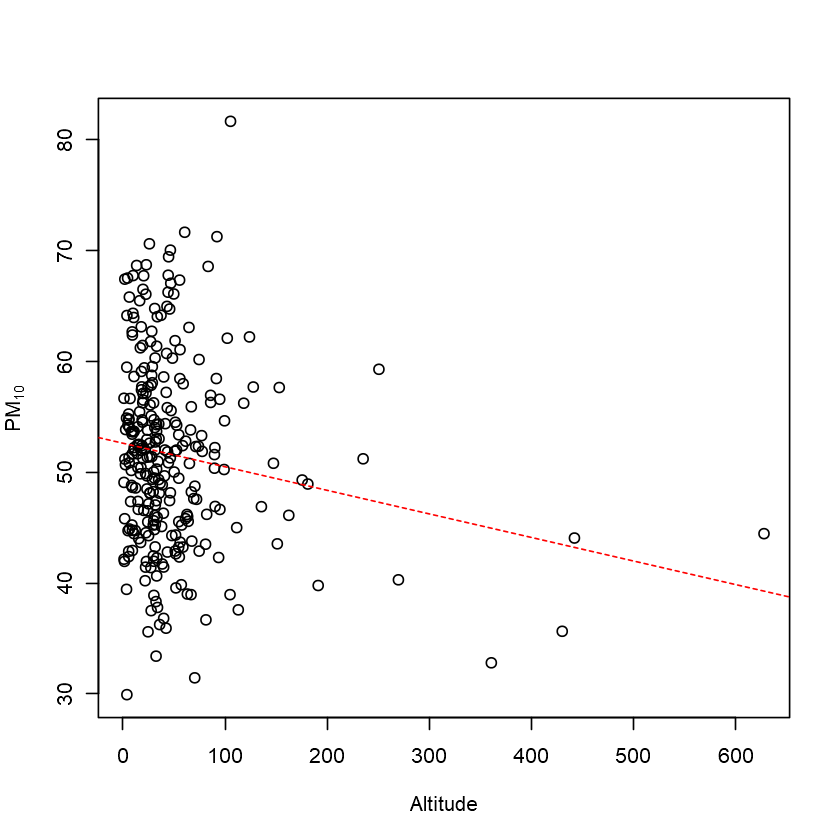


	Shapiro-Wilk normality test

data:  gv_lm1 %>% residuals
W = 0.98923, p-value = 0.03417


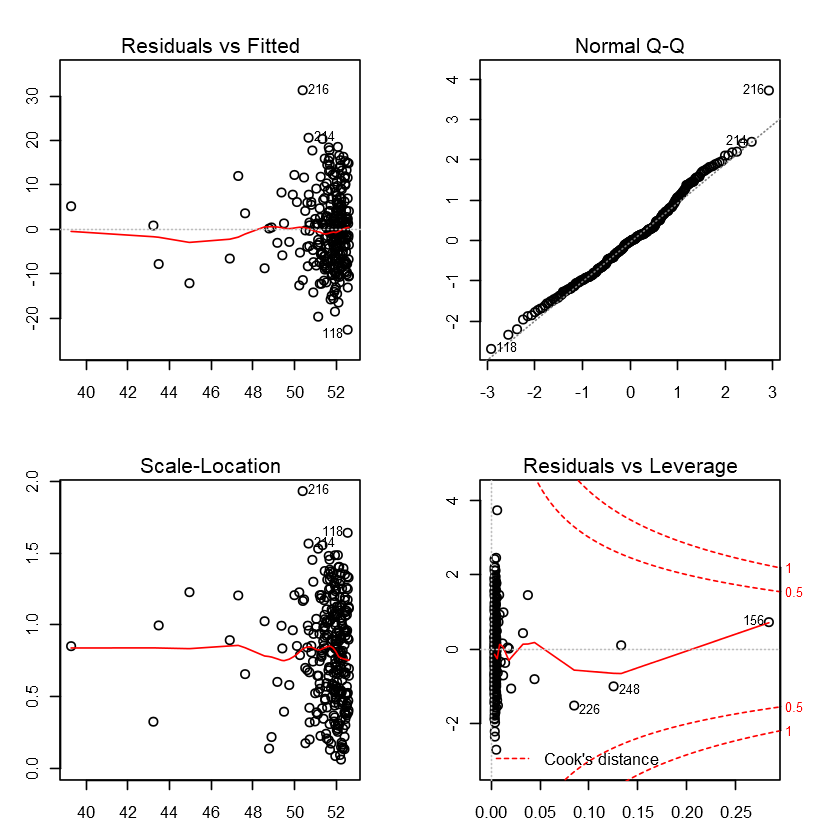

In [3]:
gv_lm1 <- lm(formula = PM10 ~ Altitude_k, 
             data = gvs)
plot(gvs$Altitude_k, gvs$PM10,
     xlab = 'Altitude', ylab = expression(PM[10]))
abline(gv_lm1, lty = 2, col = 'red')
# summary of lm object: coefficients, residuals, and model test results
summary(gv_lm1)
# lm_diagplot: diagnosis plots for lm results
lm_diagplot <- function(lm){
    par(mfrow = c(2,2), mai = rep(0.5, 4))
    plot(lm)
}
lm_diagplot(gv_lm1)
# shapiro.test: Shapiro-Wilk test for normality of residuals
shapiro.test(gv_lm1 %>% residuals)

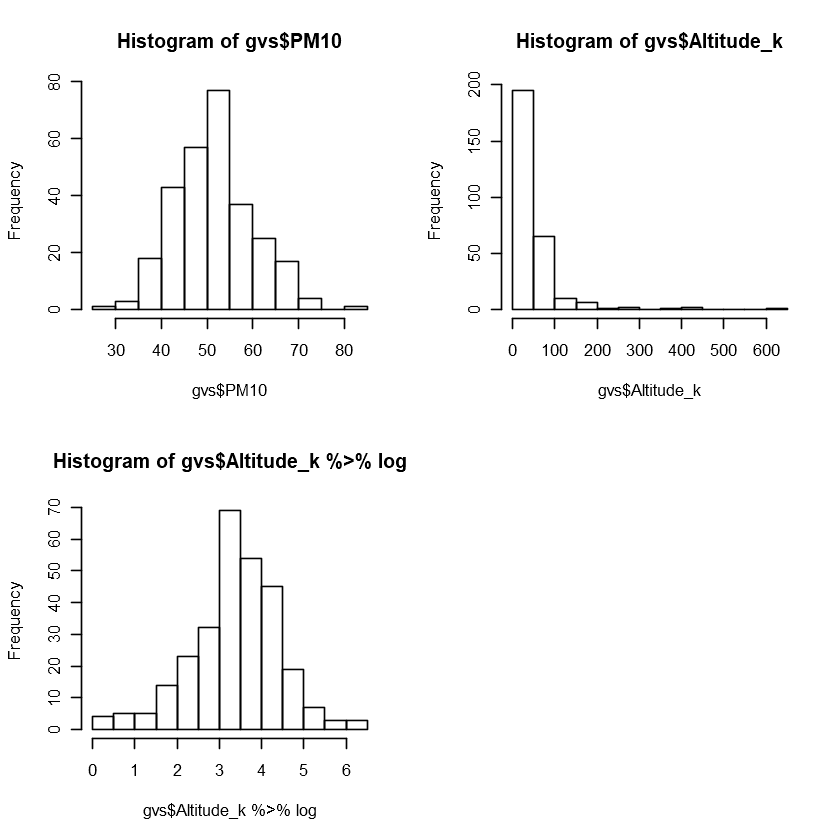

In [56]:
par(mfrow = c(2,2))
hist(gvs$PM10)
hist(gvs$Altitude_k)
hist(gvs$Altitude_k %>% log)

### 변수를 어떻게 투입할 것인가?
+ 원 변수를 그대로 투입하면 해석이 매우 용이합니다. 설명변수 한 단위 증가가 결과변수에 회귀계수만큼 변화시킨다고 얽게 이야기할 수 있습니다. 하지만 모형의 엄밀성을 위해서 변수를 변환하는 기법도 익혀 두어야 합니다.
+ 위의 히스토그램들을 살펴보십시오. 고도가 너무 낮은 값으로 치우쳐 있습니다. 통상적으로 이러한 변수들은 변환하여 정규분포에 가깝게 만든 후 투입합니다. 왜도가 높은 자료이므로 강한 로그 변환을 취합니다. 약한 변환을 원한다면 제곱근 변환을 검토할 만합니다.
    + 만약 결과변수와 설명변수가 모두 로그변환되면, 설명변수 1% 변화가 결과변수의 회귀계수 % 변화에 영향을 미친다는 '변화율' 해석이 가능하게 됩니다.
+ 투입된 `Altitude_k`에 로그 변환을 취하자 비교적 정규분포에 가까운 분포가 나타납니다.
+ 정규분포에 맞춘 `Altitude_k`를 이용해서 적합시킨 `PM10` 모형은 방금의 결과와 상이합니다. 일단 가뜩이나 낮았던 설명력이 더욱 낮아졌으며, 회귀계수가 유의하지 않게 되었습니다.
+ 이처럼 변수를 어떻게 투입하는가는 아래 두 가지 측면에서 모형을 사용하는 사람에게 영향을 줍니다.
    + 회귀계수의 해석 용이성과 의미
    + 모형 가정의 엄밀성 충족


Call:
lm(formula = PM10 ~ log(Altitude_k), data = gvs)

Residuals:
     Min       1Q   Median       3Q      Max 
-23.2600  -5.6912  -0.2771   5.2841  31.0925 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      54.2440     1.6994  31.919   <2e-16 ***
log(Altitude_k)  -0.7841     0.4795  -1.635    0.103    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.498 on 281 degrees of freedom
Multiple R-squared:  0.009429,	Adjusted R-squared:  0.005904 
F-statistic: 2.675 on 1 and 281 DF,  p-value: 0.1031


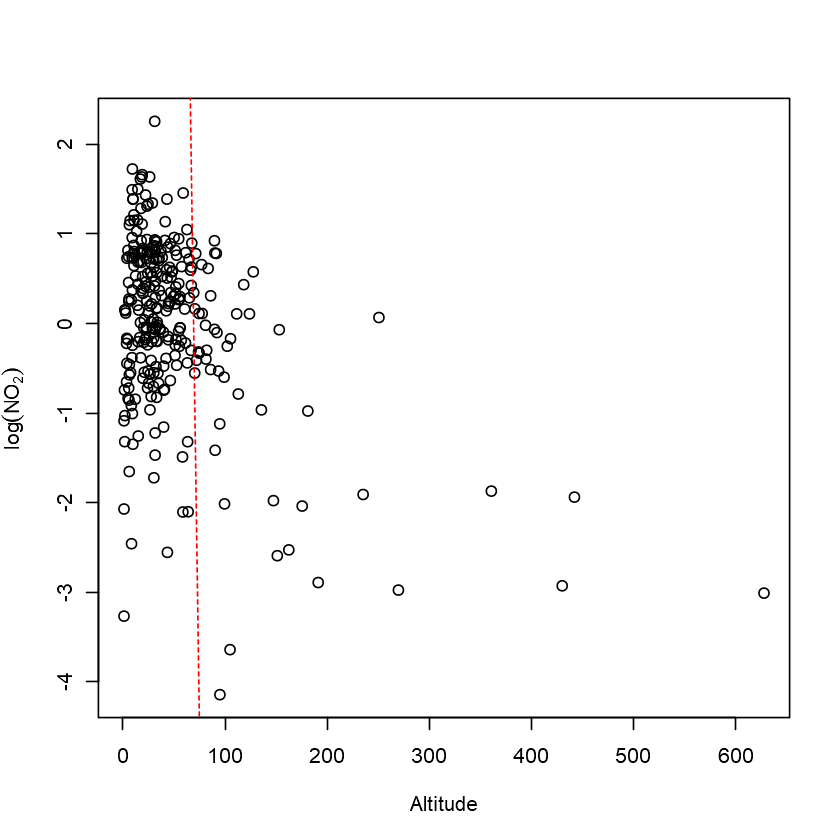

In [60]:
gv_lm1t <- lm(formula = PM10 ~ log(Altitude_k),
             data = gvs)
plot(gvs$Altitude_k, scale(log(gvs$NO2)),
     xlab = 'Altitude', ylab = expression(log(NO[2])))
abline(gv_lm1t, lty = 2, col = 'red')

summary(gv_lm1t)


Call:
lm(formula = NO2 ~ Altitude_k, data = gvs)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.024213 -0.007029 -0.000270  0.007047  0.050031 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.803e-02  7.950e-04   35.26  < 2e-16 ***
Altitude_k  -5.779e-05  9.777e-06   -5.91 9.87e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.01069 on 281 degrees of freedom
Multiple R-squared:  0.1106,	Adjusted R-squared:  0.1074 
F-statistic: 34.93 on 1 and 281 DF,  p-value: 9.866e-09


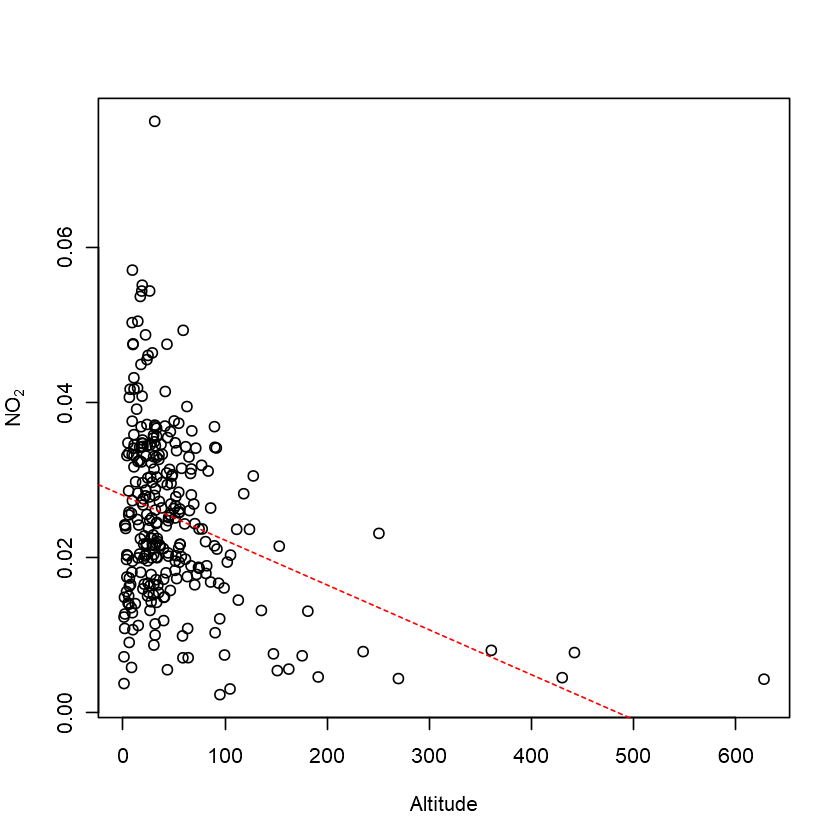


	Shapiro-Wilk normality test

data:  gv_lm2 %>% residuals
W = 0.97588, p-value = 0.0001036


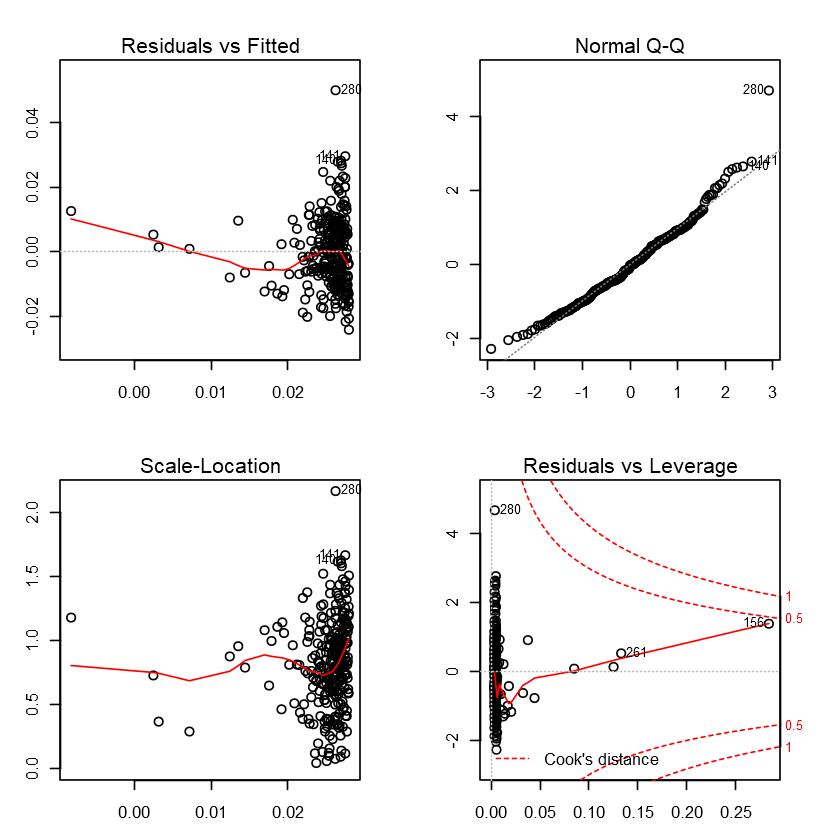

In [4]:
gv_lm2 <- lm(formula = NO2 ~ Altitude_k, 
             data = gvs)
# summary of lm object: coefficients, residuals, and model test results
plot(gvs$Altitude_k, gvs$NO2,
     xlab = 'Altitude', ylab = expression(NO[2]))
abline(gv_lm2, lty = 2, col = 'red')

summary(gv_lm2)
lm_diagplot(gv_lm2)
# shapiro.test: Shapiro-Wilk test for normality of residuals
shapiro.test(gv_lm2 %>% residuals)

## 3. Multiple Linear Regression
+ __다중회귀분석__이란 결과변수를 설명하는 변수가 여러 개인 때의 회귀분석을 말합니다.
    + 이 때부터는 사후진단 플롯은 쉽게 볼 수 있지만 위 사례처럼 변수와의 관계를 직접적으로 시각화하여 보기에는 어려움이 따릅니다.
    + 그러나 개별 변수의 독립적인 영향을 보는 방법 (ceteris paribus 분석)을 통해서 개별 변수를 보다 심도있게 볼 수 있게 됩니다.
    + 위에서 간략히 언급되었던 __다중공선성__ 문제를 살펴보기 위해서 아래에서는 `mctest::omcdiag`나 `mctest::imcdiag`를 이용합니다.
    + y와 x를 `matrix` 형태로 투입해야 함에 유의하시기 바랍니다.
+ 아래 예시에서는 마찬가지로 `lm`을 이용하되, `formula`에서 우변에 들어가는 변수가 여러 개가 된 점에 유의하십시오.
+ 이해를 돕기 위하여 투입 변수에 대해서 간략히 설명드립니다.
    + `Alt_k_below_50_1000`: 주변 1000m의 30m 너비 도넛 모양 폴리곤 안에서 고도가 50m 이상 낮은 셀들의 비율을 의미합니다.
    + `B_bem_5_0500`: 반지름 500m 버퍼 안에 거주하는 운수업 종사자의 총 수입니다.
    + `Road_LLW_0300`: 반지름 300m 버퍼 안에 있는 도로의 면적합입니다.
    + `vkt_total__00300`: 모든 차종에 대한 반지름 300m 버퍼 안의 차량총이동거리(Vehicle-Kilometer-Travel)입니다.
+ 일단 모든 변수는 10% 유의수준에서 유의합니다. `vkt` 관련 변수를 제하면 5% 유의수준에서 유의합니다.
    + __유의수준__이란, 검정이 사실이 아닐 확률이라고 이해할 수 있습니다. 문헌에서는 $\alpha$로 표시합니다.
    + 유의수준이 5%(0.05)라는 말은, 검정을 100번 수행했을 때 영가설(회귀계수에 대해 말하자면 회귀계수가 0이라는 가설)을 기각하지 못할 확률이 5% 정도 된다는 말이며, 우리는 95% 정도 회귀계수가 0이 아님을 신뢰할 수 있다는 의미입니다.
    
    
+ `effects::allEffects` 함수는 다른 변수가 평균으로 __동일할 때__, 특정 변수의 변화가 결과변수의 크기에 어떠한 영향을 미치는지를 볼 수 있게 해 줍니다.
    + `allEffects`에는 `lm` 모델이 들어갑니다. 실행 결과를 `plot`하면 위에서 말한 결과들이 관찰됩니다.
    + 개별 변수의 회귀계수는 다시금 effect plot에서 확인됩니다.


Call:
lm(formula = PM10 ~ Alt_k_below_50_1000 + B_bem_5_0500 + Road_LLW_0300 + 
    vkt_total__00300, data = gvs)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.7339  -5.5181  -0.6894   4.9868  30.9481 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.115e+01  1.053e+00  48.557  < 2e-16 ***
Alt_k_below_50_1000 -1.729e+01  3.642e+00  -4.748 3.29e-06 ***
B_bem_5_0500        -2.108e-03  1.059e-03  -1.991   0.0474 *  
Road_LLW_0300        9.551e-05  4.207e-05   2.271   0.0239 *  
vkt_total__00300     8.756e-06  4.987e-06   1.756   0.0802 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.031 on 278 degrees of freedom
Multiple R-squared:  0.1247,	Adjusted R-squared:  0.1121 
F-statistic: 9.903 on 4 and 278 DF,  p-value: 1.668e-07


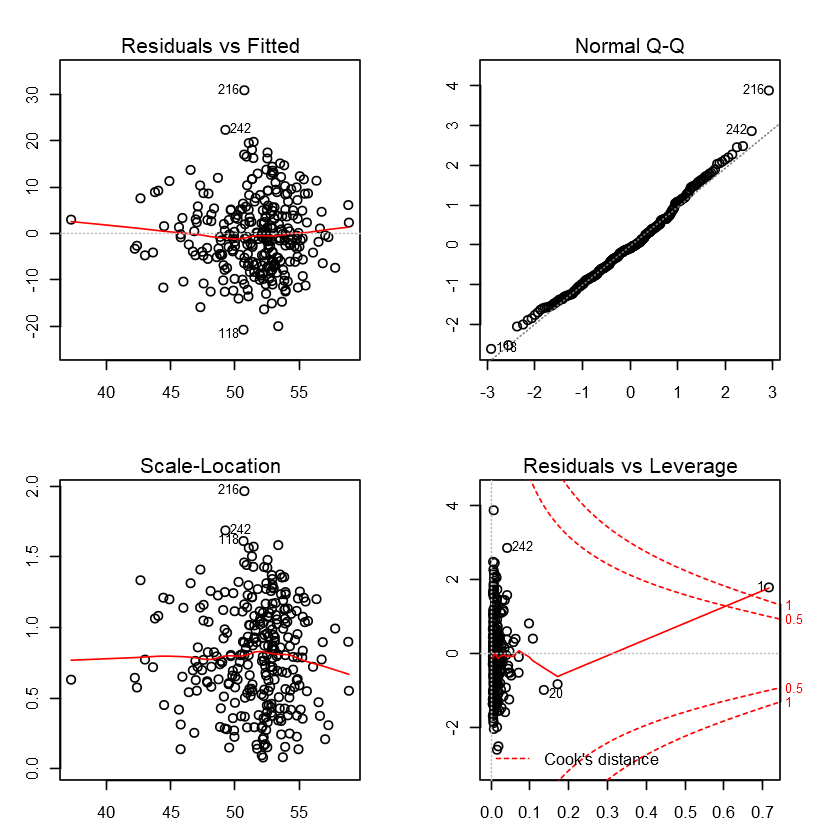


Call:
lm(formula = PM10 ~ Alt_k_below_50_1000 + B_bem_5_0500 + Road_LLW_0300, 
    data = gvs)

Residuals:
    Min      1Q  Median      3Q     Max 
-21.294  -5.278  -0.631   4.842  30.561 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.142e+01  1.046e+00  49.182  < 2e-16 ***
Alt_k_below_50_1000 -1.763e+01  3.650e+00  -4.829 2.27e-06 ***
B_bem_5_0500        -1.861e-03  1.053e-03  -1.766   0.0784 .  
Road_LLW_0300        1.056e-04  4.183e-05   2.525   0.0121 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 8.061 on 279 degrees of freedom
Multiple R-squared:  0.115,	Adjusted R-squared:  0.1055 
F-statistic: 12.09 on 3 and 279 DF,  p-value: 1.845e-07


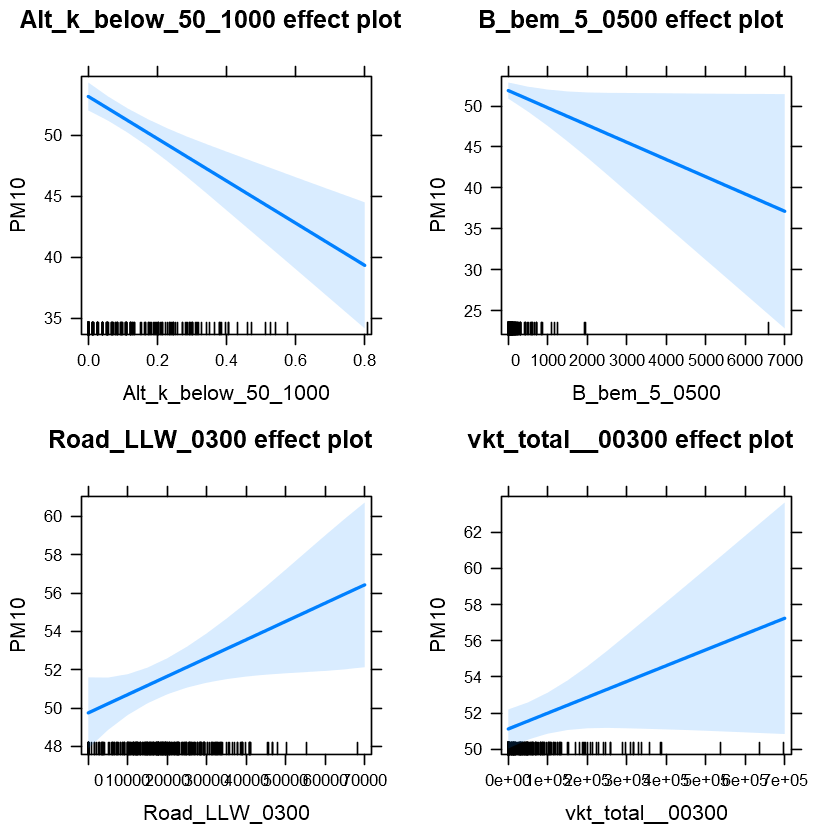

In [53]:
gv_lm3 <- lm(formula = PM10 ~ Alt_k_below_50_1000 + B_bem_5_0500 + Road_LLW_0300 + vkt_total__00300, 
             data = gvs)
summary(gv_lm3)
lm_diagplot(gv_lm3)
effects::allEffects(gv_lm3) %>% plot

gv_lm4 <- lm(formula = PM10 ~ Alt_k_below_50_1000 + B_bem_5_0500 + Road_LLW_0300, 
             data = gvs)
summary(gv_lm4)

## 4. Best Subset Regression
+ 고려하는 변수가 많을 때, 어떤 변수가 최종 모델에 투입될 것인지를 결정해야 합니다. 이를 위해서 자동화된 프로시저를 이용하거나 자신이 프로시저를 자동화하여 모델을 만드려는 목적에 맞으며, 회귀계수가 유의한 설명변수들의 집합을 찾아야 합니다. 이를 best subset이라 합니다. 
+ Best subset을 이용한 regression은 `leaps`에서 찾을 수 있습니다.
    + `leaps::leaps`는 소규모 데이터셋에,
    + `leaps::regsubsets`는 대규모 데이터셋에 적합한 함수이며, 함수 개수에 따라서 소요시간이 기하급수적으로 길어지므로 유의하시기 바랍니다.
    + 위 두 함수에서 `nvmax` 인수는 회귀모형에 포함될 변수의 최대 갯수를 지정합니다. best subset 탐색시간은 이 최대 갯수에 의존합니다. 참고로 `nvmax`
+ 아래 예시에서는 고도 관련 변수, 도로 관련 변수, 교통량 관련 변수, 인구 관련 변수들을 투입하여 best subset을 찾는 과정을 보여줍니다.

In [49]:
leap1 <- leaps::regsubsets(y = gvs$PM10, 
                           x = gvs %>% dplyr::select(starts_with('vkt'), starts_with('Alt'), starts_with('Road'), starts_with('POP')) %>% as.matrix, 
                           really.big = FALSE,
                           nvmax = 5) # maximum number of variables to be 5

+ 투입된 설명변수가 최대 5개가 되도록 설정하였습니다. `leap1` 객체에는 `exhaustive`, 즉 모든 변수의 조합을 조사하는 방식으로 최적 모형을 찾아낸 결과가 포함되어 있습니다.
+ 여기에 `summary` 함수를 적용하면 변수 개수 별로 포함된 변수가 `"*"`로 표시됩니다. 
+ 그 아래 코드 블록에서는 5개 설명변수를 사용하여 회귀분석할 때의 결과를 표출하였습니다.

In [61]:
summary(leap1, all.best = FALSE, nbest = 5)
#?summary.regsubsets

Subset selection object
47 Variables  (and intercept)
                    Forced in Forced out
vkt_total__00300        FALSE      FALSE
vkt_total__01000        FALSE      FALSE
vkt_total__02500        FALSE      FALSE
vkt_total__05000        FALSE      FALSE
Alt_a_above_20_1000     FALSE      FALSE
Alt_a_above_20_5000     FALSE      FALSE
Alt_a_above_50_1000     FALSE      FALSE
Alt_a_above_50_5000     FALSE      FALSE
Alt_a_below_20_1000     FALSE      FALSE
Alt_a_below_20_5000     FALSE      FALSE
Alt_a_below_50_1000     FALSE      FALSE
Alt_a_below_50_5000     FALSE      FALSE
Alt_k_above_20_1000     FALSE      FALSE
Alt_k_above_20_5000     FALSE      FALSE
Alt_k_above_50_5000     FALSE      FALSE
Alt_k_below_20_1000     FALSE      FALSE
Alt_k_below_20_5000     FALSE      FALSE
Alt_k_below_50_1000     FALSE      FALSE
Alt_k_below_50_5000     FALSE      FALSE
Altitude_a              FALSE      FALSE
Altitude_k              FALSE      FALSE
Road_L_0025             FALSE      FALSE
Roa

In [62]:
form = PM10 ~ Road_LW_5000 + Road_LW_0050 + Road_L_5000 + Alt_k_below_50_1000 + Alt_a_above_50_1000
leap1.sub6 <- lm(form, data = gvs)
summary(leap1.sub6)


Call:
lm(formula = form, data = gvs)

Residuals:
     Min       1Q   Median       3Q      Max 
-20.9250  -5.4092  -0.3996   4.4714  30.3000 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          4.864e+01  1.338e+00  36.359  < 2e-16 ***
Road_LW_5000         2.289e-04  4.167e-05   5.492 8.99e-08 ***
Road_LW_0050         8.039e-03  2.207e-03   3.642 0.000322 ***
Road_L_5000         -6.952e-04  1.273e-04  -5.461 1.05e-07 ***
Alt_k_below_50_1000 -1.571e+01  3.628e+00  -4.330 2.08e-05 ***
Alt_a_above_50_1000 -6.709e+00  4.171e+00  -1.608 0.108888    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.562 on 277 degrees of freedom
Multiple R-squared:  0.2267,	Adjusted R-squared:  0.2128 
F-statistic: 16.24 on 5 and 277 DF,  p-value: 4.772e-14


In [69]:
mctest::imcdiag(x = model.matrix(form, gvs), y = gvs$PM10)

Warning message in summary.lm(lm(x[, i] ~ x[, -i])):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(lm(x[, i] ~ x[, -i])):
"essentially perfect fit: summary may be unreliable"


Call:
mctest::imcdiag(x = model.matrix(form, gvs), y = gvs$PM10)


All Individual Multicollinearity Diagnostics Result

                          VIF    TOL         Wi         Fi Leamer      CVIF
(Intercept)            1.9914 0.5022    54.9250    68.9041     NA    2.0385
Road_LW_5000        1215.0921 0.0008 67260.7000 84379.3980 0.0287 1243.8080
Road_LW_0050           1.0795 0.9264     4.4021     5.5225 0.9625    1.1050
Road_L_5000         1214.9319 0.0008 67251.8251 84368.2644 0.0287 1243.6440
Alt_k_below_50_1000    1.1540 0.8666     8.5295    10.7003 0.9309    1.1812
Alt_a_above_50_1000    1.0626 0.9411     3.4664     4.3487 0.9701    1.0877
                    Klein
(Intercept)             1
Road_LW_5000            1
Road_LW_0050            0
Road_L_5000             1
Alt_k_below_50_1000     0
Alt_a_above_50_1000     0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test

Alt_k_below_50_1000 , coefficient(s) are non-significant may be due to m

In [71]:
form2 = PM10 ~ Road_LW_5000 + Road_LW_0050 + Alt_k_below_50_1000 + Alt_a_above_50_1000
leap1.sub7 <- lm(form2, data = gvs)
summary(leap1.sub7)
mctest::imcdiag(x = model.matrix(form2, gvs), y = gvs$PM10)


Call:
lm(formula = form2, data = gvs)

Residuals:
     Min       1Q   Median       3Q      Max 
-22.6028  -5.6510  -0.8137   4.9391  30.3064 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          5.083e+01  1.341e+00  37.904  < 2e-16 ***
Road_LW_5000         1.420e-06  1.397e-06   1.016  0.31033    
Road_LW_0050         7.678e-03  2.318e-03   3.313  0.00105 ** 
Alt_k_below_50_1000 -1.643e+01  3.809e+00  -4.314 2.23e-05 ***
Alt_a_above_50_1000 -5.769e+00  4.378e+00  -1.318  0.18868    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.945 on 278 degrees of freedom
Multiple R-squared:  0.1435,	Adjusted R-squared:  0.1311 
F-statistic: 11.64 on 4 and 278 DF,  p-value: 9.393e-09


Warning message in summary.lm(lm(x[, i] ~ x[, -i])):
"essentially perfect fit: summary may be unreliable"Warning message in summary.lm(lm(x[, i] ~ x[, -i])):
"essentially perfect fit: summary may be unreliable"


Call:
mctest::imcdiag(x = model.matrix(form2, gvs), y = gvs$PM10)


All Individual Multicollinearity Diagnostics Result

                       VIF    TOL      Wi      Fi Leamer   CVIF Klein
(Intercept)         1.9470 0.5136 65.8147 88.0685     NA 2.0918     1
Road_LW_5000        1.2381 0.8077 16.5495 22.1454 0.8987 1.3302     1
Road_LW_0050        1.0785 0.9272  5.4552  7.2997 0.9629 1.1587     0
Alt_k_below_50_1000 1.1524 0.8677 10.5937 14.1758 0.9315 1.2382     0
Alt_a_above_50_1000 1.0608 0.9427  4.2230  5.6510 0.9709 1.1397     0

1 --> COLLINEARITY is detected by the test 
0 --> COLLINEARITY is not detected by the test

(Intercept) , Alt_k_below_50_1000 , coefficient(s) are non-significant may be due to multicollinearity

R-square of y on all x: 0.1435 

* use method argument to check which regressors may be the reason of collinearity

## Assignment
+ 위에서 수행한 분석들에서 놓친 것 한 가지를 지적하고, 해당 부분을 `dplyr`의 함수를 이용하여 데이터 수준에서 고친 후 적용하여 결과를 해석하시오.
+ NO2에 대해서 best subset 분석 (nvmax=4)을 실시하시오. 설명변수와 결과변수의 정규성에 유의하여 분석하시오.